In [9]:
import pickle as pkl
import utils
import torch
import matplotlib.pyplot as plt
import time

import train

from train import conf

In [12]:
import glob
import numpy as np
import bvcopula

animal = 'ST260'
day_name = 'Day1'
exp_pref = f'{animal}_{day_name}'
path_models = f"{conf.path2outputs}/{exp_pref}"
layer = 0

list_files = glob.glob(f"{path_models}/layer{layer}*.pkl")

with open(list_files[0],"rb") as f:
    res = pkl.load(f)
if len(list_files)>1:
    for file in list_files[1:]:
        with open(file,"rb") as f:
            res_add = pkl.load(f)
        assert res.shape==res_add.shape
        assert np.sum((res!=None) & (res_add!=None)) == 0

        res[res_add!=None] = res_add[res_add!=None]        
        
# res[66] = [[bvcopula.IndependenceCopula_Likelihood(),
#            bvcopula.FrankCopula_Likelihood(),
#            bvcopula.ClaytonCopula_Likelihood(rotation='180°'),],
#            'IndependenceFrankClayton180°',364.,13*60+(56-38)]
# res[68] = [[bvcopula.IndependenceCopula_Likelihood(),
#            bvcopula.FrankCopula_Likelihood(),
#            bvcopula.ClaytonCopula_Likelihood(rotation='180°'),],
#            'IndependenceFrankClayton180°',364.,13*60+(56-38)]
        
if np.any(res==None):
    print('Missing models: ',layer,' vs. ',np.arange(layer+1,layer+len(res)+1)[res==None])
else:
    print(f'Layer{layer} is complete and models from different devices merged')

Missing models:  0  vs.  [ 67  69  85  91 100 104 105 106 107 108]


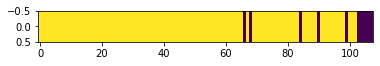

In [8]:
import matplotlib.pyplot as plt
plt.imshow((res!=None).reshape(1,-1),aspect=10)

In [168]:
def make_dependent(copula, samples):
    '''
    Since ppcf for a mixture is hard to calculate,
    this function divides the samples into N subsets proportional to self.mix,
    and then returns ppcf_i(subset_i), where ppcf_i is a ppcf of the i-th copula.
    '''
    assert copula.mix.shape[0]==len(copula.copulas)
    assert samples.shape[-1] == 2 #should be pairs
    assert copula.mix.shape[1]==samples.shape[-2] #compare sample dimensions
    # sample size (samples[0]) does not matter 
    if samples.dim()>2:
        shape = samples.shape[:-2]+copula.mix.shape
        theta_ = copula.theta.expand(shape)
        mix_ = copula.mix.expand(shape) # sample size x copulas x inputs
    else:
        theta_ = copula.theta
        mix_ = copula.mix
        

    vals = torch.zeros_like(samples[...,0])

    onehot = torch.distributions.one_hot_categorical.OneHotCategorical(
        probs=torch.einsum('i...->...i', mix_)).sample()
    print(onehot.shape)
    onehot = torch.einsum('...i->i...', onehot) # now copulas x samples
    onehot = onehot.type(torch.bool)
    
    print(onehot.shape,vals.shape)

    for i,c in enumerate(copula.copulas):
        if c.num_thetas == 0:
            vals[onehot[...,i,:]] = samples[onehot[...,i,:],0]
        else:
            print(onehot[...,i,:].shape,vals.shape,theta_.shape)
            vals[onehot[...,i,:]] = c(theta_[i,onehot[...,i,:]], 
                                           rotation=copula.rotations[i,:]).ppcf(
                                            samples[onehot[...,i,:],:])
    return vals

In [169]:
device = 'cpu'
N_points = 100
x=S = torch.linspace(0,1,N_points)
n=1
weights_file = f"{path_models}/layer{layer}/model_{exp_pref}_{layer}-{layer+n}.pth"
model = utils.get_model(weights_file, res[n-1][0], device) 
with torch.no_grad():
    f_samples = model(S).mean#rsample(torch.Size([10]))
copula = model.likelihood.get_copula(f_samples)
sample_size = torch.Size([5])
samples_shape = sample_size+f_samples.shape[-1:]+torch.Size([2])
samples = torch.empty(size=samples_shape).uniform_(1e-4, 1. - 1e-4) #torch.rand(shape) torch.rand in (0,1]

make_dependent(copula,samples).shape

# copula.rsample(sample_size).shape [5,100,2]

# if self.theta.is_cuda:
#     get_cuda_device = self.theta.get_device()
#     samples = samples.cuda(device=get_cuda_device)
# samples[...,0] = self.ppcf(samples)
# samples = self._SingleParamCopulaBase__rotate_input(samples)
#res[0]

torch.Size([2, 100, 5])
torch.Size([5, 2, 100]) torch.Size([5, 100])
torch.Size([5, 100]) torch.Size([5, 100]) torch.Size([5, 2, 100])


IndexError: The shape of the mask [5, 100] at index 0 does not match the shape of the indexed tensor [2, 100] at index 0

In [6]:

# path_models = f'/home/nina/outputs/{exp_pref}'

with open(f"{conf.path2outputs}/{exp_pref}/models_layer{layer}.pkl","rb") as f:
    model_list=pkl.load(f)
model_list
# train.merge_results(path_models, layer)
# train.transform2next_layer(exp_pref,layer,'cpu')

FileNotFoundError: [Errno 2] No such file or directory: '/disk/scratch/nkudryas/outputs/layer0_models.pkl'

In [4]:
# Assume we were have a good, uncorrupted list of models in a single file
with open(f"{conf.path2outputs}/layer{layer}_models.pkl","rb") as f:
    model_list=pkl.load(f)
# layer_width = model_list.shape[0]
# # Now load the inputs
# X,Y = utils.standard_loader(f"{path2data}/{exp_pref}_layer{layer}.pkl")
# NN = Y.shape[-1]-1
# assert layer_width==NN

NameError: name 'layer' is not defined

In [9]:
# transform all
def transform(X,Y,model_list):
    S = torch.tensor(X).float().squeeze().to(device)
    next_layer = []
    for n in range(1,Y.shape[-1]):
        # load model
        likelihoods = model_list[n-1]
        if (len(likelihoods[0])==1) and (likelihoods[1]=='Independence'):
            next_layer.append(Y[:,n])
        else:
            weights_file = f"{path_models}/layer{layer}/model_{exp_pref}_0-{n}.pth"
            model = utils.get_model(weights_file, likelihoods[0], device) 
            # load data
            samples = torch.tensor(Y[:,[n,0]]).float().squeeze().to(device) # order!

            with torch.no_grad():
                f_samples = model(S).rsample(torch.Size([10]))
            f_samples.shape

            copula = model.likelihood.get_copula(f_samples.mean(dim=0))

            next_layer.append(copula.ccdf(samples).cpu().numpy())
    return X,next_layer
%time X,next_layer = transform(X,Y,model_list)

CPU times: user 2min 1s, sys: 1.95 s, total: 2min 3s
Wall time: 6.13 s


In [10]:
# next_layer.append(Y[:,-1])
assert len(next_layer)==NN
NN

102

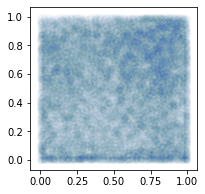

In [12]:
plt.figure(figsize=(3,3))
plt.scatter(next_layer[0],next_layer[1],alpha=0.01)

In [13]:
import numpy as np
data = {}
data['X'] = X
data['Y'] = np.array(next_layer).T

In [14]:
with open(f"{path2data}/{exp_pref}_layer{layer+1}.pkl","wb") as f:
    pkl.dump(data,f)

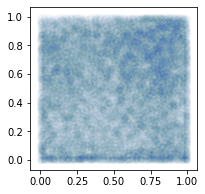

In [15]:
X,Y = utils.standard_loader(f"{path2data}/{exp_pref}_layer{layer+1}.pkl",0,1)
plt.figure(figsize=(3,3))
plt.scatter(*Y.T,alpha=0.01)

In [16]:
f"{path2data}/{exp_pref}_layer{layer+1}.pkl"

'/home/nina/VRData/Processing/pkls/ST260_Day1_layer7.pkl'

## Individual pair

In [38]:
n1=order[0]
n2=order[1]
# load model
likelihoods = utils.get_likelihoods(f"{path_models}/{exp_pref}/summary.pkl",n1,n2)
weights_file = f"{path_models}/{exp_pref}/model_{n1}-{n2}.pth"
model = utils.get_model(weights_file, likelihoods, device) 
# load data
X,Y = utils.load_experimental_data(path_exp, animal, day_name, n2, n1)
S = torch.tensor(X).float().squeeze().to(device)
samples = torch.tensor(Y).float().squeeze().to(device)

[0.001 0.001] [0.999 0.999]


In [39]:
with torch.no_grad():
    f_samples = model(S).rsample(torch.Size([10]))
f_samples.shape

torch.Size([10, 3, 21471])

In [50]:
copula = model.likelihood.get_copula(f_samples.mean(dim=0))
model.likelihood.likelihoods

[GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 ), GumbelCopula_Likelihood(
   (quadrature): GaussHermiteQuadrature1D()
 )]

tensor(0.2226, device='cuda:1')


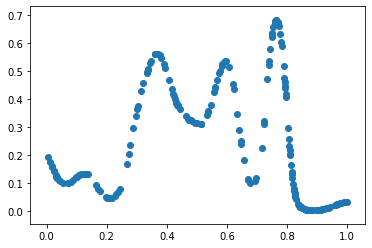

In [51]:
plt.scatter(X[::100],copula.mix.cpu().numpy()[0,::100])
print(copula.mix[0].mean())

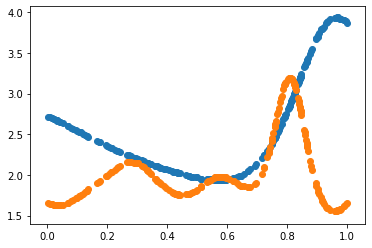

In [52]:
plt.scatter(X[::100],copula.theta.cpu().numpy()[0,::100])
plt.scatter(X[::100],copula.theta.cpu().numpy()[1,::100])

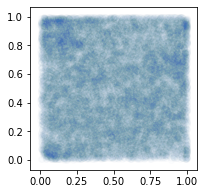

In [53]:
plt.figure(figsize=(3,3))
plt.scatter(copula.ccdf(samples).cpu().numpy(),Y[:,1],alpha=0.01)

In [44]:
new_Y0 = copula.make_dependent(torch.stack([copula.ccdf(samples),samples[...,1]],dim=1))

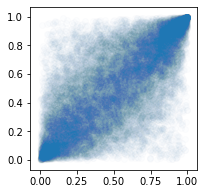

In [45]:
plt.figure(figsize=(3,3))
plt.scatter(*Y.T,alpha=0.01)

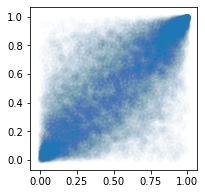

In [46]:
plt.figure(figsize=(3,3))
plt.scatter(new_Y0.cpu().numpy(),Y[:,1],alpha=0.01)

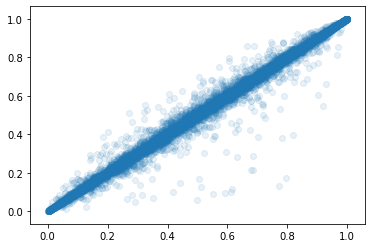

In [47]:
plt.scatter(new_Y0.cpu().numpy(),Y[:,0],alpha=0.1)

In [48]:
x2 = copula.ccdf(samples).cpu().numpy()

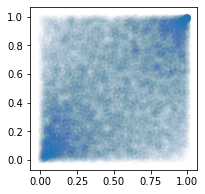

In [49]:
plt.figure(figsize=(3,3))
plt.scatter(x1,x2,alpha=0.01)